In [1]:
%load_ext autoreload
%autoreload 2

# import copy
import os
import numpy as np
import matplotlib.pyplot as plt

import imageio.v2 as imageio
from IPython.display import Markdown, display, Video
from io import BytesIO

from utils import bce_loss_function, brier_loss_function, grad_bce_loss_wrt_sigmoid_model, grad_brier_loss_wrt_sigmoid_model
from utils import create_computation_graph_linear, computation_graph_sigmoid, activation_function_sigmoid, Arrow3D

from configs import cg_rl_R01 as cg
from configs import cg_rl_R201



## 2. Regression from $f:\mathbb{R} \rightarrow [0,1]$

Now, our goal is to learn a linear model (in the parameters) that, given some continuous input $x$ we learn to associate a probability distribution over variable name $t$, which takes the value of $0$ or $1$. This is also known as logistic regression. We will simulate an example in which for each input $x$ we might have the chance with either probability $1$ or $0$ to belong to some class.

In our problem $x$ will be the weight and $y$ will represent the probability of being a dog. The other class is being a cat.


$$
\begin{split}
(x_1,t_1) &= (-0.13459237,0)\\
(x_2,t_2) &= (-3.3015387,0)\\
(x_3,t_3) &= (0.74481176,0)\\
(x_4,t_4) &= (2.62434536,1)\\
(x_5,t_5) &= (0.38824359,1)\\
(x_6,t_6) &= (0.47182825,1)\\
(x_7,t_7) &= (-0.07296862,1)\\
\end{split}
$$


### 2.1: Plot data 

**Task**: Create numpy arrays containing the $x$ and $t$ data. This data should be represented as matrices with rows representing each data entry and columns the dimension of the input and output. Plot the data layer using matplotlib.

Use blue color (C0) and asterisc $*$ and orange color (C1) and circle $o$ to differentiate classes. 

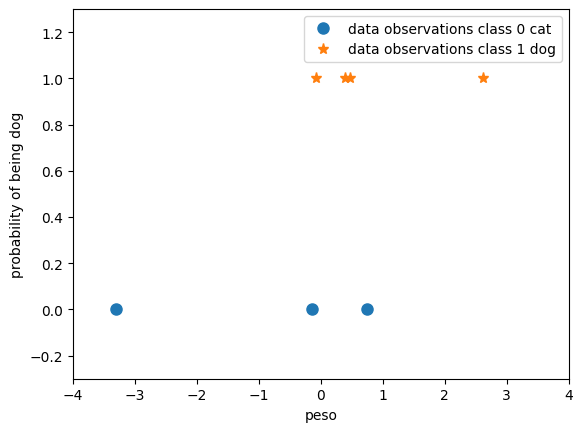

In [2]:
## =============== ##
## Define our data ##
## =============== ##
color_c0 = 'C0'
color_c1 = 'C1'

# input to our model. Represents time in seconds
x_data = np.array([-0.13459237,-3.3015387,0.74481176,2.62434536,0.38824359,0.47182825,-0.07296862]).reshape(7,1)
# outputs associated to each input. Represents cantidad de lluvia in mm^3
t_data = np.array([0,0,0,1,1,1,1]).reshape(7,1)


## display
idx_class0 = t_data == 0
idx_class1 = t_data == 1
plt.plot(x_data[idx_class0],t_data[idx_class0],'o', color = color_c0, markersize = 8, label = r'data observations class 0 cat')
plt.plot(x_data[idx_class1],t_data[idx_class1],'*', color = color_c1,markersize = 8, label = r'data observations class 1 dog')
plt.xlabel(cg.data_x_name)
plt.ylabel(cg.data_y_name)
plt.xlim([cg.data_x_lim_l,cg.data_x_lim_u])
plt.ylim([cg.data_y_lim_l,cg.data_y_lim_u])
plt.legend()

### 2.2 Plot possible plaussible linear models explaining this data

A linear model is a model with two parameters $w$ and $b$ which implements the following computational graph to predict a possible plaussible value for the probability of $t=1$, which we name $y$. Note that since a linear model is an unbounded model, we need to map the output of the linear model into a point in the unit hypercube. This is done through what are called link functions. Though there are many possible link functions we will use the canonical link function for this problem which is the sigmoid, with expression:

$$
f(x) = \frac{1}{1 + \exp^{-x}}
$$

The computational graph which gives a probability distribution over $t$, given $x$, is given by:

$$
\begin{split}
z = w\cdot x + b\\
p(t=1 \mid x) = y = \frac{1}{1 + \exp^{-z}} 
\end{split}
$$

**Task:** Plot 3 possible plaussible linear models, alongside with the data (basically repeat the code in step 2.1). You can choose them manually or generate them randomly. You will need the parameters of these models later in the assesment. You can either save them into your favourite python data structure. Another way to generate them later is to re-seed numpy so that on random generation the same random numbers are generated. 

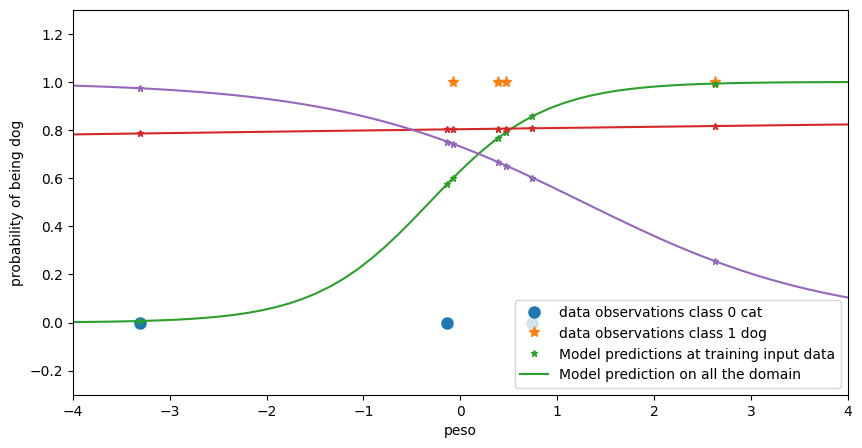

In [3]:
## ======================================================================= ##
## display possible functions depending on different values of $w$ and $b$ ##
## ======================================================================= ##

## fix seed so that randomness is controlled.
np.random.seed(cg.seed)

## figure
fig, ax = plt.subplots(1,1, figsize=(10,5))

## number of points in the domain used to plot the functions 
N_points_domain = cg.N_domain_x

# domain over where we want to plot the function implemented by the NNet
x_range = np.linspace(cg.data_x_range_l,cg.data_x_range_u, N_points_domain).reshape((N_points_domain,1))

## display
idx_class0 = t_data == 0
idx_class1 = t_data == 1
ax.plot(x_data[idx_class0],t_data[idx_class0],'o', color = color_c0, markersize = 8, label = 'data observations class 0 cat')
ax.plot(x_data[idx_class1],t_data[idx_class1],'*', color = color_c1,markersize = 8, label = 'data observations class 1 dog')
ax.set_xlabel(cg.data_x_name)
ax.set_ylabel(cg.data_y_name)
ax.set_xlim([cg.data_x_lim_l,cg.data_x_lim_u])
ax.set_ylim([cg.data_y_lim_l,cg.data_y_lim_u])

## ===========================================
## Neural network specification for each layer

# neurons of input layer
n_in = 1
# neurons of output layer
n_out = 1

## ================================================================================
## Create several possible functions that our specific neural network can implement
for i in range(3):

    # initialize one of our networks
    w, b = create_computation_graph_linear(n_in,n_out)

    # projection from input x to output y through computational graph
    y_range = computation_graph_sigmoid(x_range,w,b)

    # check how this computational_graph predicts at the inputs denote by our observed data X.
    y_data = computation_graph_sigmoid(x_data,w,b)

    if i == 0:
        ax.plot(x_data, y_data,'*', markersize = 5, color = f"C{i+2}", label = 'Model predictions at training input data')
        ax.plot(x_range,y_range, color = f"C{i+2}", label = 'Model prediction on all the domain' )
    else:
        ax.plot(x_data, y_data,'*', markersize = 5,  color = f"C{i+2}")
        ax.plot(x_range,y_range, color = f"C{i+2}")

ax.legend(loc = 'lower right')

### 2.3 Compute the loss.

For this problem of classification, we need a similar concept of distance but between two probability distributions. It turns out that the Squared Euclidean distance in such a problem is a valid distance, known in the literature as Brier Score (a proper scoring rule). Also, we will use the binary cross entropy (another proper scoring rule known as the log-score). Both are generalized entropies obtained from different Bregman Divergences.


$$
\begin{split}
L_{\text{Brier}} &= \sum_{n=1}^N (t_n-y_n)^2\\
L_{\text{BCE}} &= -\sum_{n=1}^N t_n\log(y_n) + (1-t_n)\cdot\log(1-y_n)
\end{split}
$$

Compute the loss function associated to each of the linear models in step 2.2. Plot it in a figure alongside each of the functions. To do so, complete the following tasks.

**Task:** Create two python functions that implement the above losses. The functions receive vector $t$ and vector $y$ containing all targets and all predictions. Returns another vector containing the loss per pair of elements. 

```python
def bce_loss_function(t,y):
    return ...
```

```python
def brier_loss_function(t,y):
    return ...
```

Note that since the BCE loss can take minus infinite values when evaluating the logarithm of $0$, it is convenient to clip such cases with very small values such as $1e-12$. In other words when we find that a log will give a value of $-\infty$ we subsitute this value with a small value. This can be done by:

```python
loss[loss == np.inf] = 1e12
loss[loss == -np.inf] = -1e12
```

**Task:** Compute the loss function associated to each of the linear models in step 2.2. Plot it in a figure alongside each of the linear functions. You can also print the values in the console.

/tmp/ipykernel_634764/2479758812.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(x_data[j], y_data[j] - cg.losses[loss_itet].total_loss_display_inc, f"$d(y_{j+1},t_{j+1})={float(loss[j]):.2}$", fontsize=8, ha="center", color = f"C{i+1}")
/tmp/ipykernel_634764/2479758812.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(x_data[j], y_data[j] + j*cg.losses[loss_itet].total_loss_display_inc, f"$d(y_{j+1},t_{j+1})={float(loss[j]):.2}$", fontsize=8, ha="center", color = f"C{i+1}")


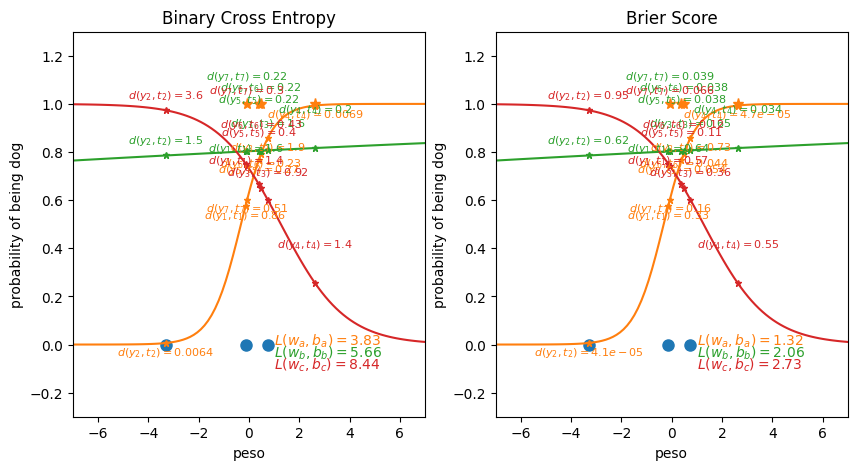

In [4]:
## fix seed so that randomness is controlled.
np.random.seed(cg.seed)

## number of points in the domain used to plot the functions 
N_points_domain = cg.N_domain_x

# domain over where we want to plot the function implemented by the NNet
x_range = np.linspace(cg.data_x_range_l,cg.data_x_range_u, N_points_domain).reshape((N_points_domain,1))

## get number of losses to display
num_losses = len(cg.losses)

## display data again
fig, ax_list = plt.subplots(1,num_losses, figsize=(10,5))
if num_losses == 1:
    ax_list = [ax_list]

idx_class0 = t_data == 0
idx_class1 = t_data == 1

for loss_itet,ax in enumerate(ax_list):

    ax.plot(x_data[idx_class0],t_data[idx_class0],'o', color = color_c0, markersize = 8, label = 'data observations class 0 cat')
    ax.plot(x_data[idx_class1],t_data[idx_class1],'*', color = color_c1,markersize = 8, label = 'data observations class 1 dog')

    ax.set_xlabel(cg.data_x_name)
    ax.set_ylabel(cg.data_y_name)
    ax.set_title(cg.losses[loss_itet].loss_name)
    ax.set_ylim([cg.losses[loss_itet].loss_y_lim_l,cg.losses[loss_itet].loss_y_lim_u])
    ax.set_xlim([cg.losses[loss_itet].loss_x_lim_l,cg.losses[loss_itet].loss_x_lim_u])    

## =========================================================================================
## Create several possible functions that our specific neural network can implement and plot

# to save parameters to use later
w_save = []
b_save = []

for i, model_id in zip(range(3),['a','b','c']):

    # initialize one of our networks
    w, b = create_computation_graph_linear(n_in,n_out)

    # projection from input x to output y through computational graph
    y_range = computation_graph_sigmoid(x_range,w, b)

    # check how this computational_graph predicts at the inputs denote by our observed data X.
    y_data = computation_graph_sigmoid(x_data,w,b)
    
    # for each of the losses compute the loss and display:
    for loss_itet,ax in enumerate(ax_list):
        loss = cg.losses[loss_itet].loss_fun(t_data, y_data)
        
        if i == 0:
            ax.plot(x_data, y_data,'*', markersize = 5, color = f"C{i+1}", label = 'Predictions at training input data')
            ax.plot(x_range,y_range, color = f"C{i+1}", label = 'function on all the domain' )

            for j in range(len(x_data)):
                ax.text(x_data[j], y_data[j] - cg.losses[loss_itet].total_loss_display_inc, f"$d(y_{j+1},t_{j+1})={float(loss[j]):.2}$", fontsize=8, ha="center", color = f"C{i+1}") 

            ax.text(1,-cg.losses[loss_itet].total_loss_display_inc*i, f"$L(w_{model_id},b_{model_id}) = {float(np.sum(loss)):.2f}$", color = f"C{i+1}")    

        else:
            ax.plot(x_data, y_data,'*', markersize = 5,  color = f"C{i+1}")
            ax.plot(x_range,y_range, color = f"C{i+1}")

            for j in range(len(x_data)):
                ax.text(x_data[j], y_data[j] + j*cg.losses[loss_itet].total_loss_display_inc, f"$d(y_{j+1},t_{j+1})={float(loss[j]):.2}$", fontsize=8, ha="center", color = f"C{i+1}")

            ax.text(1,-cg.losses[loss_itet].total_loss_display_inc*i, f"$L(w_{model_id},b_{model_id}) = {float(np.sum(loss)):.2f}$", color = f"C{i+1}")    
            



### 2.4 Compute the loss function.

A loss function is a function of the parameters and the data, i.e. we can write:

$$
\begin{split}
L_{\text{Brier}}(w,x,t) &= \sum_{n=1}^N (t_n-y_n)^2\\
L_{\text{BCE}}(w,x,t) &= - \sum_{n=1}^N  t_n\log(y_n) + (1-t_n)\cdot\log(1-y_n)\\
\end{split}
$$

**Task:** Fix a value for the bias parameter $b=0.5$, and plot the loss function w.r.t possible plaussible parameter values for $w$. Highlight the loss associated to the 3 possible plausible linear models you selected in section 2.2.

In [5]:
## ============================================================================== ##
## display loss as a function of weight parameter (loss incurred by each network) ##
## ============================================================================== ##
## Let's see the associated loss to each possible function but seeing the loss
## as a function of the weight parameter. To do so we fix the bias value.
## We show two different losses: squared (top) and absolute ( bottom )
## I repeat code from above but computing and plotting the loss.


## ======================== ##
## Simulation configuration ##
## ======================== ##
fixed_bias = cg.fixed_bias

## fix seed so that randomness is controlled.
np.random.seed(cg.seed)

## for data plotting
idx_class0 = t_data == 0
idx_class1 = t_data == 1

## number of points in the domain used to plot the functions 
N_points_domain = cg.N_domain_x

## get number of losses to display
num_losses = len(cg.losses)

## ================ ##
## For plot display ##
## ================ ##
## create figure box
fig, ax_list = plt.subplots(num_losses,2, figsize = (10,10))
# wrap into list of list for this case since when num_losses is 1 it is not wrapped.
if num_losses == 1:
    ax_list = [ax_list]

# Create temporary file for video creation
video_filename = "/tmp/aux.mp4"

## video writer
writer = imageio.get_writer(video_filename, format="FFMPEG", mode="I", fps=1, codec="libx264")

## =============================================
## Specify input output to the computation graph
D_in = 1
D_out = 1

## ================================================================================
## Create several possible functions that our specific neural network can implement

# to save individual losses, expected losses and parameters used
loss_acc = [[] for i in range(num_losses)]
expected_loss_acc = [[] for i in range(num_losses)]

# domain over where we want to plot the function implemented by the NNet
x_range = np.linspace(cg.data_x_range_l,cg.data_x_range_u, N_points_domain).reshape((N_points_domain,1))

w_acc = []
w_range = []
# Compute the loss function over 100 possible neural net.
for i in range(cg.N_models_simulation):
    
    # initialize one of our networks
    w, b = create_computation_graph_linear(n_in,n_out, std = 4)

    # projection from input x to output y through computational graph
    y_range = computation_graph_sigmoid(x_range,w, fixed_bias)

    # check how this computational_graph predicts at the inputs denote by our observed data X.
    y_data = computation_graph_sigmoid(x_data,w, fixed_bias)

    # for each of the losses:
    for loss_itet,ax in enumerate(ax_list):
        
        # compute the loss at the predictions
        loss = cg.losses[loss_itet].loss_fun(t_data, y_data)
    
        # accumulate the loss and save both individual and accumulated losses
        loss_acc[loss_itet].append(loss)
        expected_loss_acc[loss_itet].append(np.sum(loss))
        
    # save parameter used to compute the loss
    w_range.append(np.squeeze(w))
    w_acc.append(w)

# sort loss and weights to interactive plot later
idx = np.argsort(w_range)
sorted_expected_loss_acc = []
for _ in expected_loss_acc:
    sorted_expected_loss_acc.append(np.array(_)[idx])
## ===================================================================== ##
## Display different models sequentially, alongside its loss, in a video ##

# Display the loss over the possible plaussible functions.
w_old = []
expected_loss_old = [ [] for _ in range(num_losses)]

for i,w in zip(range(cg.N_models_display),w_acc):  
    
    ## repeat the projection from input x to output y through computational graph
    y_range = computation_graph_sigmoid(x_range,w, fixed_bias)

    # check how this computational_graph predicts at the inputs denote by our observed data X.
    y_data = computation_graph_sigmoid(x_data,w, fixed_bias)
    
    ## for subsequent plotting
    w = np.squeeze(w)
    
    ## ============== ##
    ## Start plotting ##
    ## ============== ##
    
    ## clean up points
    for loss_itet in range(num_losses):
        for ax in ax_list[loss_itet]:
            ax.cla()

    ## display data and loss function
    for loss_itet in range(num_losses):
        
        ## plot data
        ax_1 = ax_list[loss_itet][0]
        ax_1.plot(x_data[idx_class0],t_data[idx_class0],'o', color = color_c0, markersize = 8, label = 'data observations class 0 cat')
        ax_1.plot(x_data[idx_class1],t_data[idx_class1],'*', color = color_c1,markersize = 8, label = 'data observations class 1 dog')
        ax_1.set_xlabel(cg.data_x_name)
        ax_1.set_ylabel(cg.data_y_name)
        ax_1.set_title(cg.losses[loss_itet].loss_name)
        ax_1.set_ylim([cg.losses[loss_itet].loss_y_lim_l,cg.losses[loss_itet].loss_y_lim_u])
        ax_1.set_xlim([cg.losses[loss_itet].loss_x_lim_l,cg.losses[loss_itet].loss_x_lim_u])
        
        ## plot loss function
        ax_2 = ax_list[loss_itet][1]
        ax_2.plot(np.array(w_range)[idx], sorted_expected_loss_acc[loss_itet] )
        ax_2.set_xlabel('weight values')
        ax_2.set_ylabel(cg.losses[loss_itet].loss_name)
        
        ## Plot function
        ax_1.plot(x_data[idx_class0], y_data[idx_class0],'x', markersize = 5, color = f"C0", label = 'Predictions at training input data')
        ax_1.plot(x_data[idx_class1], y_data[idx_class1],'x', markersize = 5, color = f"C1")
        ax_1.plot(x_range,y_range, color = f"C2", label = 'function on all the domain' )

        ## Plot individual losses
        for j in range(len(x_data)):
            ax_1.text(x_data[j], j*cg.losses[loss_itet].per_point_loss_display_y_inc, f"$d(y_{j+1},t_{j+1})={float(loss_acc[loss_itet][i][j]):.2}$", fontsize=8, ha="center", color = f"C1") 
    
        ## Plot expected loss
        ax_1.text(cg.losses[loss_itet].total_loss_display_x,cg.losses[loss_itet].total_loss_display_y, f"$L(w = {w:.2f},b = {fixed_bias}) = {expected_loss_acc[loss_itet][i]:.2f}$", color = f"C1")  
        ax_1.text(cg.losses[loss_itet].total_loss_display_x,cg.losses[loss_itet].total_loss_display_y-2*cg.losses[loss_itet].total_loss_display_inc, f"$y = {w:.2f} \cdot x + {fixed_bias}$", color = f"C1")  
    
        ## Plot already displayed losses
        ax_2.plot(w_old, expected_loss_old[loss_itet], '*', color = 'C0')

        ## Plot the loss in the loss function view
        ax_2.plot(w, expected_loss_acc[loss_itet][i], '*', color = f"C1")
        ax_2.text(w, expected_loss_acc[loss_itet][i]+cg.losses[loss_itet].total_loss_display_loss_plot_inc, f"$L(w = {w:.2f},b = {fixed_bias}) = {expected_loss_acc[loss_itet][i]:.2f}$", color = f"C1")    
   
        # save old loss to display in next figure iteration
        expected_loss_old[loss_itet].append(expected_loss_acc[loss_itet][i])

    # save old to display in next figure
    w_old.append(w)

    ## Cortesía de chatGPT (desde linea siguiente hasta el final de esta celda):
    ## save images for later display
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)
    
    buf.seek(0)
    frame = imageio.imread(buf) 
    writer.append_data(frame)  

writer.close() 
plt.close()

/home/jmaronasm/Desktop/INVESTIGACION_DOCENCIA/DOCENCIA_Y_APUNTES/CLASES/CUNEF/24_25_RNA_Master/Deep-Learning-and-Machine-Learning/utils.py:39: RuntimeWarning: divide by zero encountered in log
  loss[idx_0] = np.log(1-y[idx_0])
/tmp/ipykernel_634764/3680259762.py:144: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax_1.text(x_data[j], j*cg.losses[loss_itet].per_point_loss_display_y_inc, f"$d(y_{j+1},t_{j+1})={float(loss_acc[loss_itet][i][j]):.2}$", fontsize=8, ha="center", color = f"C1")
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvi

In [6]:
# Mostrar el video en Jupyter Notebook
display(Video(data=video_filename, embed=True))
os.remove(video_filename)

**Task:** Now plot the loss function w.r.t both parameters $w$ and $b$. Highlight the loss associated to the 3 possible plausible linear models you selected in section 2.2. You can also plot the associated model in another plot, as before. Simulate a total number of $100$ values for $w$ with corresponding $100$ values for $b$.

In [7]:
## ======================================================================================= ##
## display loss as a function of weight and bias parameter (loss incurred by each network) ##
## ======================================================================================= ##
## Let's see the associated loss to each possible function but seeing the loss
## as a function of the weight and bias parameter. 
## We show two different losses: squared (top) and absolute ( bottom )

## fix seed so that randomness is controlled.
np.random.seed(cg.seed)

## number of points in the domain used to plot the functions 
N_points_domain = cg.N_domain_x

## get number of losses to display
num_losses = len(cg.losses)

## for data plotting
idx_class0 = t_data == 0
idx_class1 = t_data == 1

## ================ ##
## For plot display ##
## ================ ##
## create figure box
fig = plt.figure(figsize = (10,10))
ax_list = []
counter = 1
for i in range(num_losses):
    ax_1 = fig.add_subplot(num_losses,2,counter)
    ax_2 = fig.add_subplot(num_losses,2,counter + 1, projection='3d')
    
    ax_2.view_init(elev=30, azim=cg.losses[i].full_loss_display_azim)
    
    counter += 2
    
    ax_list.append([ax_1,ax_2])

# Create temporary file for video creation
video_filename = "/tmp/aux.mp4"

## video writer
writer = imageio.get_writer(video_filename, format="FFMPEG", mode="I", fps=1, codec="libx264")

## ===========================================
## Neural network specification for each layer

# neurons of input layer
n_in = 1
# neurons of output layer
n_out = 1

## ===================================================================================================
## Create several possible functions that our specific neural network can implement and compute losses
'''
**optimal parameters for bce loss (global)**
weight = 1.1246184
bias = 0.12033531


**optimal parameters for brier loss (local)**
weight = 0.85201174
bias = 0.2264343
'''

expected_loss_mesh = []
for loss_itet in range(num_losses):

    ## To do so we need a mesh
    w_mesh, b_mesh = np.meshgrid(
        np.linspace(cg.losses[loss_itet].w_range_l_2d,cg.losses[loss_itet].w_range_u_2d,cg.N_models_simulation),
        np.linspace(cg.losses[loss_itet].b_range_l_2d,cg.losses[loss_itet].b_range_u_2d,cg.N_models_simulation)
    )

    # reshape x_data and t_data for computations. t_data uses broadcasting
    x_data_expanded = x_data[:,np.newaxis]
    t_data_expanded = t_data[:,np.newaxis]
    
    # compute linear projection at all pairs of points
    y_data_expanded = activation_function_sigmoid( w_mesh * x_data_expanded + b_mesh) 
    
    if cg.losses[loss_itet].loss_name == 'Binary Cross Entropy':
        # add new axis for correct indexation in the function
        t_data_expanded = np.squeeze(t_data_expanded)

    # compute loss
    _expected_loss = np.sum(cg.losses[loss_itet].loss_fun(t_data_expanded, y_data_expanded), axis = 0)
    
    ## saturate to maximum value for display
    max_val = np.max(_expected_loss[_expected_loss != np.inf ])
    min_val = np.min(_expected_loss[_expected_loss != -np.inf ])
    _expected_loss[_expected_loss == np.inf ] = max_val
    _expected_loss[_expected_loss == -np.inf ] = min_val
    
    expected_loss_mesh.append(_expected_loss)

# to save individual losses, expected losses and parameters used
loss_acc = [[] for _ in range(num_losses)]
expected_loss_acc = [[] for _ in range(num_losses)]
    
# domain over where we want to plot the function implemented by the NNet
x_range = np.linspace(cg.data_x_range_l,cg.data_x_range_u, N_points_domain).reshape((N_points_domain,1))
    
w_acc = []
w_range = []
b_acc = []
b_range = []

# Compute the loss funciton over some possible models.
for i in range(cg.N_models_display):

    # initialize one of our networks
    w, b = create_computation_graph_linear(n_in,n_out)

    # projection from input x to output y through computational graph
    y_range = computation_graph_sigmoid(x_range,w,b)

    # check how this computational_graph predicts at the inputs denote by our observed data X.
    y_data = computation_graph_sigmoid(x_data,w,b)

    for loss_itet in range(num_losses):
        
        # compute loss at the predictions
        loss = cg.losses[loss_itet].loss_fun(t_data, y_data)
        
        # acumulate loss and parameter used
        loss_acc[loss_itet].append(loss)
        expected_loss_acc[loss_itet].append(np.sum(loss))
        
    w_range.append(np.squeeze(w))
    b_range.append(np.squeeze(b))
    w_acc.append(w)
    b_acc.append(b)

## =========================================================
## Display different models sequentially, alongside its loss.
#  The first 3 ones are the ones generated in step 1.2

# variables to keep track of old weight losses display to show the overall loss function.
w_old = []
b_old = []
expected_loss_old = [ [] for _ in range(num_losses)]

for i,w,b in zip(range(len(w_acc)),w_acc,b_acc):  
    
    if i == 0 or i == 1 or i == 2:
        color = f"C{i+1}"
    else:
        color = 'C5'
    
    ## repeat the projection from input x to output y through computational graph
    y_range = computation_graph_sigmoid(x_range,w,b)

    # check how this computational_graph predicts at the inputs denote by our observed data X.
    y_data = computation_graph_sigmoid(x_data,w,b)
    
    ## for subsequent plotting
    w = np.squeeze(w)
    b = np.squeeze(b)
    
    ## clean up points
    for loss_itet in range(num_losses):
        for ax in ax_list[loss_itet]:
            ax.cla()

    ## display data and loss function
    for loss_itet in range(num_losses):
        ax_1 = ax_list[loss_itet][0]
        ax_2 = ax_list[loss_itet][1]
        
        ## plot data
        ax_1 = ax_list[loss_itet][0]
        ax_1.plot(x_data[idx_class0],t_data[idx_class0],'o', color = color_c0, markersize = 8, label = 'data observations class 0 cat')
        ax_1.plot(x_data[idx_class1],t_data[idx_class1],'*', color = color_c1,markersize = 8, label = 'data observations class 1 dog')
        ax_1.set_xlabel(cg.data_x_name)
        ax_1.set_ylabel(cg.data_y_name)
        ax_1.set_title(cg.losses[loss_itet].loss_name)
        ax_1.set_ylim([cg.losses[loss_itet].loss_y_lim_l,cg.losses[loss_itet].loss_y_lim_u])
        ax_1.set_xlim([cg.losses[loss_itet].loss_x_lim_l,cg.losses[loss_itet].loss_x_lim_u])
        
        ## display loss functions
        ax_2.plot_surface(w_mesh, b_mesh, expected_loss_mesh[loss_itet], cmap = 'gray', alpha = 0.75 )
        ax_2.set_xlabel('weight values')
        ax_2.set_ylabel('bias values')
        ax_2.set_zlabel(cg.losses[loss_itet].loss_name)
        
        ## Plot function
        ax_1.plot(x_data[idx_class0], y_data[idx_class0],'x', markersize = 5, color = f"C0", label = 'Predictions at training input data')
        ax_1.plot(x_data[idx_class1], y_data[idx_class1],'x', markersize = 5, color = f"C1")
        ax_1.plot(x_range,y_range, color = f"C2", label = 'function on all the domain' )

        ## Plot individual losses
        for j in range(len(x_data)):
            ax_1.text(x_data[j], j*cg.losses[loss_itet].per_point_loss_display_y_inc, f"$d(y_{j+1},t_{j+1})={float(loss_acc[loss_itet][i][j]):.2}$", fontsize=8, ha="center", color = color) 

        ## Plot expected loss
        ax_1.text(cg.losses[loss_itet].total_loss_display_x,cg.losses[loss_itet].total_loss_display_y, f"$L(w = {w:.2f},b = {b:.2f})= {expected_loss_acc[loss_itet][i]:.2f}$", color = color)  
        ax_1.text(cg.losses[loss_itet].total_loss_display_x,cg.losses[loss_itet].total_loss_display_y-2*cg.losses[loss_itet].total_loss_display_inc, f"$y = {w:.2f} \cdot x + {b:.2f}$", color = color)  

        ## Plot already displayed losses
        ax_2.plot(w_old, b_old, expected_loss_old[loss_itet], '*', color = 'C0')
        
        ## Plot the loss in the loss function view
        ax_2.plot(w, b, expected_loss_acc[loss_itet][i], '*', color = color)
        ax_2.text(w,b,expected_loss_acc[loss_itet][i]+cg.losses[loss_itet].total_loss_display_loss_plot_inc, f"$L(w = {w:.2f},b = {b:.2f}) = {expected_loss_acc[loss_itet][i]:.2f}$", color = color, zorder = 2, ha = 'center')       

        # save old to display in next figure. first 3 models are not added to the old list to not be plotted as old and so that we can highlight them
        # as required.
        expected_loss_old[loss_itet].append(expected_loss_acc[loss_itet][i])
    
    # first 3 models are not added to the old list to not be plotted as old and so that we can highlight them
    # as required.
    w_old.append(w)
    b_old.append(b)
    
    ## Cortesía de chatGPT (desde linea siguiente hasta el final de esta celda):
    ## save images for later display
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)

    buf.seek(0)
    frame = imageio.imread(buf) 
    writer.append_data(frame)  

writer.close() 
plt.close()

/home/jmaronasm/Desktop/INVESTIGACION_DOCENCIA/DOCENCIA_Y_APUNTES/CLASES/CUNEF/24_25_RNA_Master/Deep-Learning-and-Machine-Learning/utils.py:54: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))
/tmp/ipykernel_634764/1455561679.py:193: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax_1.text(x_data[j], j*cg.losses[loss_itet].per_point_loss_display_y_inc, f"$d(y_{j+1},t_{j+1})={float(loss_acc[loss_itet][i][j]):.2}$", fontsize=8, ha="center", color = color)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 1000) to (1008, 1008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x1

In [8]:
# Mostrar el video en Jupyter Notebook
display(Video(data=video_filename, embed=True))
os.remove(video_filename)

### 2.5 Compute the gradient of the loss function.

To optimize the loss function w.r.t. the parameters, we need to obtain the gradient of the loss function. Compute the expressions for these gradients:

$$
\begin{split}
\frac{\partial L_{\text{BCE}}}{\partial w} = \\
\frac{\partial L_{\text{BCE}}}{\partial b} = \\
\frac{\partial L_{\text{Brier}}}{\partial w} = \\
\frac{\partial L_{\text{Brier}}}{\partial b} = \\
\end{split}
$$


### 2.6 Implement gradient descent

Run gradient descent on the loss function towards computing the optimal parameters. Draw an iterated simulation where you show the current regression line with its loss in a plot, and in another plot show the loss function and the associated point corresponding to the regression line. Each iteration should show convergence. Do it for both two functions.

Try different values of the learning rate and see what happens.

**Task:** Create two functions (one per loss function) that compute the gradient of the loss function w.r.t the parameters of the model $w$ and $b$.

```python
def grad_bce_loss_wrt_sigmoid_model(x,t,w,b):
    ...
    return grad_w, grad_b

def grad_brier_loss_wrt_sigmoid_model(x,t,w,b):
    ...
    return grad_w, grad_b
```

**Task:** Fix a value of $b=0.5$ and run gradient descent only on the weight. Generate two plots. One plot represents the loss function with the loss corresponding to the weight, and the other plot should represent the points and the function. On each iteration of the algorithm the plots needs to be updated with the new value obtained by gradient descent. Use the %matplotlib tk option so that the plot gets updated.

Try different values of the learning rate.

You can initialize the model parameters to whatever you desire. Here are some options:

**Brier score:** $w=-1.4$

**BCE Loss:** $w=-8$


In [9]:
## ========================== ##
## ==== Gradient Descent ==== ##
## ========================== ##
loss_type = 'brier'

if loss_type not in ['bce', 'brier']:
    raise RuntimeError("Invalid loss type choose from bce or brier")

## ======================== ##
## Simulation configuration ##
## ======================== ##
fixed_bias = cg.fixed_bias

## fix seed so that randomness is controlled.
np.random.seed(cg.seed)

## number of points in the domain used to plot the functions 
N_points_domain = cg.N_domain_x

# domain over where we want to plot the function implemented by the NNet
x_range = np.linspace(cg.data_x_range_l,cg.data_x_range_u, N_points_domain).reshape((N_points_domain,1))

## ================ ##
## For plot display ##
## ================ ##
## create figure box
fig, (ax11,ax12) = plt.subplots(1,2, figsize = (10,5))
fig.subplots_adjust(wspace=0.5)

# Create temporary file for video creation
video_filename = "/tmp/aux.mp4"

## video writer
writer = imageio.get_writer(video_filename, format="FFMPEG", mode="I", fps=1, codec="libx264")

## =============================================
## Specify input output to the computation graph
D_in = 1
D_out = 1

## ============================================
## Get the loss function over which we optimize
w_range = np.linspace(cg.losses_named[loss_type].w_range_l,cg.losses_named[loss_type].w_range_u,cg.N_models_simulation).reshape((cg.N_models_simulation,D_in,D_out))

## get predictions for each model
y_data = computation_graph_sigmoid(x_data, w_range, fixed_bias)

## compute loss
if loss_type == 'bce':
    loss_range = cg.losses_named[loss_type].loss_fun(np.tile(t_data,(cg.N_models_simulation,1,1)), y_data)
else:
    loss_range = cg.losses_named[loss_type].loss_fun(t_data, y_data)

## accumulate loss per datapoint
loss_acc_range = np.sum(loss_range, axis = 1)

## squeeze and display
loss_acc_range = np.squeeze(loss_acc_range)
w_range = np.squeeze(w_range)

## Display different models sequentially, alongside its loss.

# display loss function
ax11.plot(w_range, loss_acc_range, color = 'C0')
ax11.set_xlabel('Weight')
ax11.set_ylabel('Loss')

# Initialize parameters
w = np.array([cg.losses_named[loss_type].w_init]).reshape(D_in,D_out)

## gradient descent parameters
lr = 0.9 # try 0.1, 0.01, 0.15, 0.21 to show: fast convergence, slow convergence, convergence with bumping, divergence
epochs = 10

for e in range(epochs):

    ## forward plus backward
    grad_w, _ = cg.losses_named[loss_type].grad_loss_fun(x_data,t_data, w, fixed_bias)
    
    ## compute function at current parameter value
    function = computation_graph_sigmoid(x_range, w, fixed_bias)

    ## compute predictions at current parameter value
    y_data = computation_graph_sigmoid(x_data, w, fixed_bias)

    ## compute loss at current parameter value
    loss = cg.losses_named[loss_type].loss_fun(t_data,y_data)    
    loss_acc = np.sum(loss)

    ## get the gradient function at the point w (tangent at the point)
    gradient_function_w_at_current_w = grad_w * w_range + loss_acc - grad_w * w
    
    ## compute loss on updated parameters
    w_n = w-lr*grad_w
    
    ## function on new parameters
    function_n = computation_graph_sigmoid(x_range, w_n, fixed_bias)
    
    ## predictions with new parameters
    y_data_n = computation_graph_sigmoid(x_data, w_n, fixed_bias)

    ## compute loss at current parameter value
    loss_n = cg.losses_named[loss_type].loss_fun(t_data, y_data_n)
    loss_acc_n = np.sum(loss_n)
    
    ## ============= ##
    ## ============= ##
    ## START DRAWING ##
    ## ============= ##
    ## ============= ##
    # Clear previous data
    ax11.clear()
    ax12.clear()
    
    w_plot = np.squeeze(w)
    w_plot_n = np.squeeze(w_n)
    grad_w_plot = np.squeeze(grad_w)
    x_data_plot = np.squeeze(x_data)
    t_data_plot = np.squeeze(t_data)
    y_data_plot = np.squeeze(y_data)
    y_data_plot_n = np.squeeze(y_data_n)
    loss_plot = np.squeeze(loss)
    loss_plot_n = np.squeeze(loss_n)

    ## =========================== ##
    ## prediction function picture ##
    ax12.plot(x_range,function, color = 'C1', label = 'function: y = w*x')
    ax12.plot(x_data,t_data,'o', markersize = 8, label = 'data observations')

    ## plot loss associated at each point and draw line between dots to highliht what the loss measures
    for idx, (xi, ti, yi, sl) in enumerate(zip(x_data_plot,t_data_plot,y_data_plot,loss_plot)):
        if idx == 0:
            ax12.plot(xi,yi, 'x', color = 'C1', label = 'network prediction')
        else:
            ax12.plot(xi,yi, 'x', color = 'C1')
        ax12.plot([xi,xi], [ti, yi], '--',color = f"C1", alpha = 0.5)
        ax12.text(xi, yi, f'{sl:.2f}', fontsize=12, va='top', color = f"C1" ) 

    # label function with the weight at that moment
    ax12.text(x_range[-20],function[-20], f'w = {w_plot:.2f}', color = 'k', fontsize = 12)
    
    ax12.text(0.5, 1.6, f"Iteration {e}, {loss_type} loss = {loss_acc:.2f}", fontsize=12, va='bottom', color = f"C1" ) 
    ax12.set_xlabel(cg.data_x_name)
    ax12.set_ylabel(cg.data_y_name)
    ax12.set_ylim([cg.data_y_lim_l_gd_pred_fun,cg.data_y_lim_u_gd_pred_fun])
    ax12.legend()
    
    ## ===================== ##
    ## loss function picture ##
    ## 0. label and axis limits
    ax11.set_xlabel('Weight')
    ax11.set_ylabel('Loss')
    ax11.set_ylim([cg.losses_named[loss_type].gd_loss_fun_y_lim_l,cg.losses_named[loss_type].gd_loss_fun_y_lim_u])
    ax11.set_xlim([cg.losses_named[loss_type].gd_loss_fun_x_lim_l,cg.losses_named[loss_type].gd_loss_fun_x_lim_u])
          
    ## 1. display loss function
    ax11.plot(w_range, loss_acc_range, color = 'C0', label = 'loss', zorder = 20)    
    
    ## 2. display current weight
    ax11.plot(w_plot, cg.losses_named[loss_type].gd_loss_fun_display_param_y + cg.losses_named[loss_type].gd_loss_fun_display_param_inc_y, '*', color = 'C1', label = 'current weight', zorder = 50, markersize = 10)
    ax11.text(w_plot + 1, cg.losses_named[loss_type].gd_loss_fun_display_param_y + cg.losses_named[loss_type].gd_loss_fun_display_param_inc_y , f"w = {w_plot:.2f}", fontsize=12, va='bottom', color = f"C1" , zorder = 50)
    ax11.legend(loc = 'upper left')    
        
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)
    
    buf.seek(0)
    frame = imageio.imread(buf) 
    writer.append_data(frame) 
    
    ## animation by drawing horizontal lines on current parameter and updated parameter values
    ax11.vlines(np.squeeze(w), ymin=cg.losses_named[loss_type].gd_loss_fun_display_param_y, ymax=loss_acc, color='k', linestyles='dotted', zorder = -50)

    ## 3. display current loss
    ax11.plot(w_plot, loss_acc, 'o', color = 'C0', label = 'loss at current weight', zorder = 20)
    ax11.text(w_plot + 0.5, loss_acc , f"loss = {loss_acc:.2f}", fontsize=12, va='bottom', color = "C0" , zorder = 50)
    ax11.legend(loc = 'upper left')
    
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)
    
    buf.seek(0)
    frame = imageio.imread(buf) 
    writer.append_data(frame) 
    
    ## 4. display the gradient function
    ax11.plot(w_range, np.squeeze(gradient_function_w_at_current_w), color = 'C2', label = 'gradient function: f(w) = grad_w * w + loss - grad_w * w', zorder = 20)
    ax11.text(w_range[-1], np.squeeze(gradient_function_w_at_current_w)[-1], f"grad_w = {grad_w_plot:.2f}", fontsize=12, va='bottom', color = f"C2" , zorder = 200) 
    ax11.legend(loc = 'upper left')
    
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)
    
    buf.seek(0)
    frame = imageio.imread(buf) 
    writer.append_data(frame) 
    
    ## draw rest of lines to show update
    ax11.hlines(y = loss_acc, xmin=w_plot_n, xmax=w_plot, color='k', linestyles='dotted', zorder = -50)
    
    writer.append_data(frame)
    
    ax11.vlines(w_plot_n, ymin=cg.losses_named[loss_type].gd_loss_fun_display_param_y , ymax=loss_acc, color='k', linestyles='dotted', zorder = -50)
    
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)
    
    buf.seek(0)
    frame = imageio.imread(buf) 
    writer.append_data(frame) 

    ## 5. display new weight
    ax11.plot(w_plot_n, cg.losses_named[loss_type].gd_loss_fun_display_param_y + cg.losses_named[loss_type].gd_loss_fun_display_param_inc_y, '*', color = 'C3', label = 'updated weight: w_new = w - lr*grad_w', zorder = 200, markersize = 10)
    ax11.text(w_plot_n, cg.losses_named[loss_type].gd_loss_fun_display_param_y - 10*cg.losses_named[loss_type].gd_loss_fun_display_param_inc_y, f"w_new = {w_plot:.2f} -{lr:.2f}*{grad_w_plot:.2f} = {w_plot-lr*grad_w_plot:.2f}", fontsize=12, va='bottom', color = f"C3" , zorder = 200) 
    ax11.legend(loc = 'upper left')
        
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)
    
    buf.seek(0)
    frame = imageio.imread(buf) 
    writer.append_data(frame) 
    
    ## 6. display updated function
    ax12.plot(x_range,function_n, color = 'C3')

    ## plot squared loss associated at each point and draw line between dots to highliht what the loss measures
    for idx, (xi, ti, yi, sl) in enumerate(zip(x_data_plot,t_data_plot,y_data_plot_n,loss_plot_n)):
        if idx == 0:
            ax12.plot(xi,yi, 'x', color = 'C3')
        else:
            ax12.plot(xi,yi, 'x', color = 'C3')
        ax12.plot([xi,xi], [ti, yi], '--',color = f"C3", alpha = 0.5)
        ax12.text(xi, yi, f'{sl:.2f}', fontsize=12, va='top', color = f"C3" ) 

    # label function with the weight at that moment
    ax12.text(x_range[5],function_n[5], f'w = {w_plot_n:.2f}; b = {fixed_bias:.2f}', color = 'C3', fontsize = 12)
    
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)
    
    buf.seek(0)
    frame = imageio.imread(buf) 
    writer.append_data(frame) 
    
    ## update parameter with gradient descent, for the next update
    w = w-lr*grad_w
    
writer.close() 
plt.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 500) to (1008, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [10]:
# Mostrar el video en Jupyter Notebook
display(Video(data=video_filename, embed=True))
os.remove(video_filename)

### 2.6.2: Run gradient descent on the full model.

#### Illustrative simulation

**Task:** Similar to the previous step, but now optimize for both $w$ and $b$. Use the following initializations:

**BCE Loss:** $w=-50$, $b=-150$.

**Brier Score:** $w=-0.5$, $b=-1$. 

In [11]:
## ======================================================================================= ##
## display loss as a function of weight and bias parameter (loss incurred by each network) ##
## ======================================================================================= ##
## Let's see the associated loss to each possible function but seeing the loss
## as a function of the weight and bias parameter. 
## We show two different losses: squared (top) and absolute ( bottom )
loss_type = 'bce'

if loss_type not in ['brier', 'bce']:
    raise RuntimeError("Invalid loss type choose from bce or brier")

# Create temporary file for video creation
video_filename = "/tmp/aux.mp4"

## video writer
writer = imageio.get_writer(video_filename, format="FFMPEG", mode="I", fps=1, codec="libx264")       
    
## create figure box
fig = plt.figure(figsize = (10,5))
ax11 = fig.add_subplot(121, projection='3d')
ax11.view_init(elev=30, azim=cg.losses_named[loss_type].full_loss_display_azim)
ax12 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0.5)

## number of points in the domain used to plot the functions 
N_points_domain = cg.N_domain_x

# domain over where we want to plot the function implemented by the NNet
x_range = np.linspace(cg.data_x_range_l,cg.data_x_range_u, N_points_domain).reshape((N_points_domain,1))


## ===========================================
## Neural network specification for each layer

# neurons of input layer
n_in = 1
# neurons of output layer
n_out = 1

## ================================================================================
## Create several possible functions that our specific neural network can implement
## first of all draw loss function against a set of parameters

## To do so we need a mesh
w_mesh, b_mesh = np.meshgrid(
    np.linspace(cg.losses_named[loss_type].w_range_l_2d,cg.losses_named[loss_type].w_range_u_2d,cg.N_models_simulation),
    np.linspace(cg.losses_named[loss_type].b_range_l_2d,cg.losses_named[loss_type].b_range_u_2d,cg.N_models_simulation)
)

# reshape x_data and t_data for computations. t_data uses broadcasting.
x_data_expanded = x_data[:,np.newaxis]
t_data_expanded = t_data[:,np.newaxis]

# compute linear projection at all pairs of points
y_data_expanded = activation_function_sigmoid(w_mesh*x_data_expanded + b_mesh)

# compute loss
if loss_type == 'bce':
    loss_acc_mesh = np.sum(cg.losses_named[loss_type].loss_fun(np.squeeze(t_data_expanded), y_data_expanded), axis = 0)
else:
    loss_acc_mesh = np.sum(cg.losses_named[loss_type].loss_fun(t_data_expanded, y_data_expanded), axis = 0)

max_val = np.max(loss_acc_mesh[loss_acc_mesh != np.inf ])
min_val = np.min(loss_acc_mesh[loss_acc_mesh != -np.inf ])
loss_acc_mesh[loss_acc_mesh == np.inf ] = max_val
loss_acc_mesh[loss_acc_mesh == -np.inf ] = min_val
   
ax11.plot_surface(w_mesh, b_mesh, loss_acc_mesh, cmap = 'gray')
ax11.set_xlabel('weight values')
ax11.set_ylabel('bias values')
ax11.set_zlabel(f'{loss_type} loss function')

# Initialize parameters
w = np.array([cg.losses_named[loss_type].w_init_full]).reshape(n_in,n_out)
b = np.array([cg.losses_named[loss_type].b_init_full])

"""
**optimal parameters for bce loss (global)**
weight = 1.1246184
bias = 0.12033531


**optimal parameters for mse loss (local)**
weight = 0.85201174
bias = 0.2264343
"""

## gradient descent parameters
lr = 3
epochs = 20

for e in range(epochs):
    
    ## forward plus backward
    grad_w, grad_b = cg.losses_named[loss_type].grad_loss_fun(x_data,t_data, w, b)

    ## compute function at current parameter value
    function = computation_graph_sigmoid(x_range, w, b)

    ## compute predictions at current parameter value
    y_data = computation_graph_sigmoid(x_data, w, b)

    ## compute loss at current parameter value
    loss = cg.losses_named[loss_type].loss_fun(t_data, y_data)
    
    loss_acc = np.sum(loss)
    
    ## compute loss on updated parameters
    w_n = w-lr*grad_w
    b_n = b-lr*grad_b
    
    ## function on new parameters
    function_n = computation_graph_sigmoid(x_range, w_n, b_n)
    
    ## predictions with new parameters
    y_data_n = computation_graph_sigmoid(x_data, w_n, b_n)

    ## compute loss at current parameter value
    loss_n = cg.losses_named[loss_type].loss_fun(t_data, y_data_n)

    loss_acc_n = np.sum(loss_n)
    
    ## ============= ##
    ## ============= ##
    ## START DRAWING ##
    ## ============= ##
    ## ============= ##
    # Clear previous data
    ax11.clear()
    ax12.clear()
    
    w_plot = np.squeeze(w)
    b_plot = np.squeeze(b)
    
    w_plot_n = np.squeeze(w_n)
    b_plot_n = np.squeeze(b_n)

    x_data_plot = np.squeeze(x_data)
    t_data_plot = np.squeeze(t_data)
    y_data_plot = np.squeeze(y_data)
    y_data_plot_n = np.squeeze(y_data_n)
    loss_plot = np.squeeze(loss)
    loss_plot_n = np.squeeze(loss_n)
    
    ## ================ ##
    ## function picture ##
    ax12.plot(x_range,function, color = 'C1', label = 'function: y = w*x + b')
    ax12.plot(x_data,t_data,'o', markersize = 8, label = 'data observations')

    ## plot squared loss associated at each point and draw line between dots to highliht what the loss measures
    for idx, (xi, ti, yi, sl) in enumerate(zip(x_data_plot,t_data_plot,y_data_plot,loss_plot)):
        if idx == 0:
            ax12.plot(xi,yi, 'x', color = 'C1', label = 'network prediction')
        else:
            ax12.plot(xi,yi, 'x', color = 'C1')
        ax12.plot([xi,xi], [ti, yi], '--',color = f"C1", alpha = 0.5)
        ax12.text(xi, yi, f'{sl:.2f}', fontsize=12, va='top', color = f"C1" ) 

    # label function with the weight at that moment
    ax12.text(x_range[-20],function[-20], f'w = {w_plot:.2f}; b = {b_plot:.2f}', color = 'C1', fontsize = 12)
    
    ax12.text(0, 1.2, f"Iteration {e}, {cg.losses_named[loss_type].loss_name} = {loss_acc:.2f}", fontsize=12, va='bottom', color = f"C1" ) 
    ax12.set_xlabel(cg.data_x_name)
    ax12.set_ylabel(cg.data_y_name)
    ax12.set_ylim([cg.data_y_lim_l_gd_pred_fun,cg.data_y_lim_u_gd_pred_fun])
    ax12.legend()
    
    ## ===================== ##
    ## loss function picture ##
    
    ## 1. display loss function
    ax11.plot_surface(w_mesh, b_mesh, loss_acc_mesh, cmap = 'gray')
    ax11.set_xlabel('weight values')
    ax11.set_ylabel('bias values')
    ax11.set_zlabel(f'{cg.losses_named[loss_type].loss_name} loss function')
    
    ## 2. display current weight
    ax11.plot(w_plot, b_plot, loss_acc, 'o', color = 'C1', label = 'current weight', zorder = 50, markersize = 5)
    ax11.text(w_plot, b_plot, loss_acc, f"(w,b) = ({w_plot:.2f},{b_plot:.2f})", fontsize=12, va='bottom', color = f"C1" , zorder = 50)
    ax11.legend()
    
    ## save image frame
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)
    
    buf.seek(0)
    frame = imageio.imread(buf) 
    writer.append_data(frame)
    
    ## 3. display the gradient arrow and updated weight
    a = Arrow3D([w_plot, w_plot_n], [b_plot, b_plot_n], [loss_acc, loss_acc_n],
                mutation_scale=20, lw=0.5, arrowstyle="-|>", color="C0")
    ax11.add_artist(a)
    ax11.legend()

    ## 4. display new weight
    ax11.plot(w_plot_n, b_plot_n, loss_acc_n, 'o', color = 'C3', label = 'updated weight', zorder = 50, markersize = 5)
    ax11.text(w_plot_n, b_plot_n, loss_acc_n, f"(w_new,b_new) = ({w_plot_n:.2f},{b_plot_n:.2f})", fontsize=12, va='bottom', color = f"C3" , zorder = 50)
    ax11.legend()
    
    ## save image frame
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)
    
    buf.seek(0)
    frame = imageio.imread(buf) 
    writer.append_data(frame)
    
    ## 6. display updated function
    ax12.plot(x_range,function_n, color = 'C3')
    ax12.plot(x_data,t_data,'o', markersize = 8, label = 'data observations')

    ## plot squared loss associated at each point and draw line between dots to highliht what the loss measures
    for idx, (xi, ti, yi, sl) in enumerate(zip(x_data_plot,t_data_plot,y_data_plot_n,loss_plot_n)):
        if idx == 0:
            ax12.plot(xi,yi, 'x', color = 'C3')
        else:
            ax12.plot(xi,yi, 'x', color = 'C3')
        ax12.plot([xi,xi], [ti, yi], '--',color = f"C3", alpha = 0.5)
        ax12.text(xi, yi, f'{sl:.2f}', fontsize=12, va='top', color = f"C3" ) 

    # label function with the weight at that moment
    ax12.text(x_range[5],function_n[5], f'w = {w_plot_n:.2f}; b = {b_plot_n:.2f}', color = 'C3', fontsize = 12)
    
    ## save image frame
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)
    
    buf.seek(0)
    frame = imageio.imread(buf) 
    writer.append_data(frame) 
    
    ## update parameter with gradient descent, for the next update
    w = w-lr*grad_w
    b = b-lr*grad_b
    
writer.close() 
plt.close()


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 500) to (1008, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [12]:
# Mostrar el video en Jupyter Notebook
display(Video(data=video_filename, embed=True))
os.remove(video_filename)

#### Run Gradient Descent

**Task:** Run gradient descent on the full model removing any fancy simulation. Run it until convergence and check whether the minimum obtained coincides with the minimum showed in the plot before. As in other assesment, you can show a plot which shows how the loss function evolves over the course of learning.

Loss 3.58 obtained using gradient descent with 1500 epochs and learning rate: 0.1
Parameters at this loss w = 1.1246183918009953, b = 0.12033512801790833


Text(0, 0.5, 'loss')

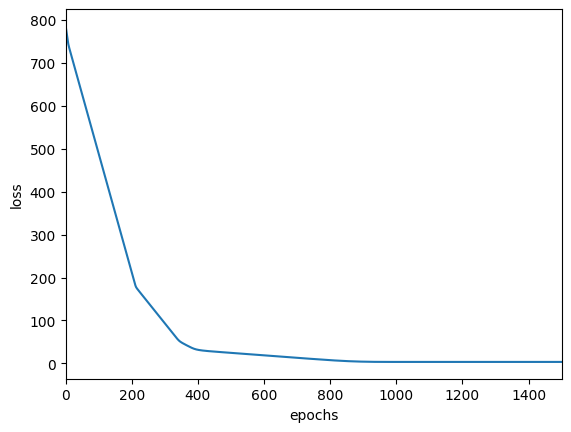

In [13]:
get_video = False

## ======================================================================================= ##
## display loss as a function of weight and bias parameter (loss incurred by each network) ##
## ======================================================================================= ##
## Let's see the associated loss to each possible function but seeing the loss
## as a function of the weight and bias parameter. 
## We show two different losses: squared (top) and absolute ( bottom )
loss_type = 'bce'

if loss_type not in ['brier', 'bce']:
    raise RuntimeError("Invalid loss type choose from bce or brier")

## ===========================================
## Neural network specification for each layer

# neurons of input layer
n_in = 1
# neurons of output layer
n_out = 1

# Initialize parameters
w = np.array([cg.losses_named[loss_type].w_init_full]).reshape(n_in,n_out)
b = np.array([cg.losses_named[loss_type].b_init_full])

"""
**optimal parameters for bce loss (global)**
weight = 1.1246184
bias = 0.12033531


**optimal parameters for mse loss (local)**
weight = 0.85201174
bias = 0.2264343
"""
fig, ax = plt.subplots(1,1)

if get_video:
    
    # Create temporary file for video creation
    video_filename = "/tmp/aux.mp4"

    ## video writer
    writer = imageio.get_writer(video_filename, format="FFMPEG", mode="I", fps=1, codec="libx264")    

## to keep loss over the course of learning
loss_acc_list = []
    
## gradient descent parameters
lr = 0.1
epochs = 1500

for e in range(epochs):
    
    ## forward plus backward
    grad_w, grad_b = cg.losses_named[loss_type].grad_loss_fun(x_data,t_data, w, b)

    ## compute predictions at current parameter value
    y_data = computation_graph_sigmoid(x_data, w, b)

    ## compute loss at current parameter value
    loss = cg.losses_named[loss_type].loss_fun(t_data, y_data)
    loss_acc = np.sum(loss)
    loss_acc_list.append(loss_acc)

    ## update parameter with gradient descent, for the next update
    w = w-lr*grad_w
    b = b-lr*grad_b
    
    if get_video:
        ax.plot(np.arange(e+1),loss_acc_list)
        ax.set_xlim([0, epochs])
        ax.set_xticks(np.arange(0, epochs, 5))
        ax.set_xlabel("epochs")
        ax.set_ylabel("loss")

        ## save image frame
        buf = BytesIO()
        fig.savefig(buf, format="png", dpi=100)

        buf.seek(0)
        frame = imageio.imread(buf) 
        writer.append_data(frame) 
    
print(f"Loss {loss_acc:.2f} obtained using gradient descent with {epochs} epochs and learning rate: {lr}")
print(f"Parameters at this loss w = {np.squeeze(w)}, b = {np.squeeze(b)}")

if get_video:
    writer.close() 

# show convergence plot
ax.plot(np.arange(e+1),loss_acc_list)
ax.set_xlim([0, epochs])
ax.set_xticks(np.arange(0, epochs, 200))
ax.set_xlabel("epochs")
ax.set_ylabel("loss")


In [14]:
if get_video:
    # Mostrar el video en Jupyter Notebook
    display(Video(data=video_filename, embed=True))
    os.remove(video_filename)

## 3. Regression from $f:\mathbb{R}^2 \rightarrow [0,1]$

The cool thing about classification problems is that colors are very usefull to visualize how the model learns and breaks the feature space into decision thresholds.

Now, our goal is to learn a model  that, given some continuous input $x \in \mathbb{R}^2$ we learn to associate a probability distribution over $x$, which we name $y$. Similar to the problem above, we will simulate an example in which for each input $x$ we might have the chance with either probability $1$ or $0$ to belong to some class. Now our input features will be $x_1$ peso and $x_2$ height.


$$
\begin{split}
(x^1_{1},x^1_{2},t^1) &= (0,1,0)\\
(x^2_{1},x^2_{2},t^2) &= (1.5,2.0,0)\\
(x^3_{1},x^3_{2},t^3) &= (2,1,0)\\
(x^4_{1},x^4_{2},t^4) &= (2.5,2,0)\\
(x^5_{1},x^5_{2},t^5) &= (3,4,1)\\
(x^6_{1},x^6_{2},t^6) &= (4,5,1)\\
(x^7_{1},x^7_{2},t^7) &= (5,1,1)\\
\end{split}
$$

In [15]:
cg = cg_rl_R201

### 3.1 Plot data

**Task:** Use blue color (C0) and asterisc $o$ and orange color (C1) and circle $*$ to differentiate classes. Use a 2 dimensional plot, where x and y axis represents the input feature coordinates, and the color and symbol represents the label. This can be done with the `plt.plot()` matplotlib's function.

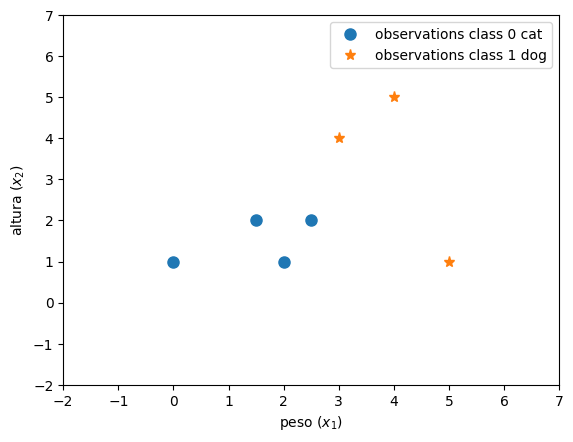

In [16]:
## =============== ##
## Define our data ##
## =============== ##

# input to our model. Represents time in seconds
x_data = np.array([[0,1],
                  [1.5,2.0],
                  [2,1],
                  [2.5,2],
                  [3,4],
                  [4,5],
                  [5,1]]).reshape(7,2)

# outputs associated to each input. Represents cantidad de lluvia in mm^3
t_data = np.array([0,0,0,0,1,1,1])

## display

idx_class0 = t_data == 0
idx_class1 = t_data == 1
plt.plot(x_data[idx_class0][:,0],x_data[idx_class0][:,1],'o', color = cg.color_class0, markersize = 8, label = f'observations class 0 {cg.name_class0}')
plt.plot(x_data[idx_class1][:,0],x_data[idx_class1][:,1],'*', color = cg.color_class1,markersize = 8, label = f'observations class 1 {cg.name_class1}')
plt.xlabel(cg.data_x1_name)
plt.ylabel(cg.data_x2_name)
plt.xlim([cg.data_x1_lim_l,cg.data_x1_lim_u])
plt.ylim([cg.data_x2_lim_l,cg.data_x2_lim_u])
plt.legend()


### 3.2 Plot possible plaussible linear models explaining this data

In this case, the linear model is a model on $\mathbb{R}^2$. A linear model on this space is a plane. Predicting possible plaussible values for $t$ know requires the following operation.

$$
\begin{split}
z = w_1\cdot x_1 + w_2 \cdot x_2 + b\\
y = \frac{1}{1 + \exp^{-z}}
\end{split}
$$

or in a more compact form

$$
\begin{split}
z = x^T w + b\\
y = \frac{1}{1 + \exp^{-z}}
\end{split}
$$

where $w$ and $x$ are now vectors:

$$
w = \begin{bmatrix} w_1 \\ w_2 \end{bmatrix}
$$

$$
x = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}
$$



**Task:** Plot 3 possible plaussible models alongside the data. Again use a two dimensional plot as above. For this visualization, rather than plotting the function itself, you can plot, with colors (use contour and contourf) what is the probability assigned by the model at each different possitions of the input vector $x$. 
You will need a grid obtained through meshgrid. On each point of the grid you can compute what is the probability assigned by the model to each of the classes (note that one is the complementary of the other). Then, if this probability value is above a threshold, then the class assigned by the model corresponds to the class being labelled as $t=1$. If it is below, it belongs to the other. You can use this decision rule to decide which class is being assigned by the model, and thus use the color that corresponds.

*Tip:* To implement this plot, one cool thing about the contour plot is that on the matrix entries given a `np.nan` value, the plot does not show nothing. This means you can first show the points assigned to a class label (those above threshold) with matrix entries given by the probability predicted by the model, in those points above the threshold, and `np.nan` in the rest. Then perform same step for points with probability points below the threshold. To see what I mean you can run the following example code:

```python
fig, ax = plt.subplots(1,1)
N_points = 500

x1, x2 = np.meshgrid(np.linspace(0,10,N_points),np.linspace(0,5,N_points))

fun = np.sin(x1)*np.cos(x2)
fun_plot = np.zeros((N_points,N_points), dtype = np.float32)

idx_1 = x1 <= 5
idx_2 = x2 <= 4

idx = idx_1 & idx_2
n_idx = ~idx

fun_plot[idx] = fun[idx]
fun_plot[n_idx] = np.nan

ax.contourf(x1,x2, fun_plot , cmap = plt.cm.get_cmap("Oranges"))

fun_plot[n_idx] = fun[n_idx]
fun_plot[idx] = np.nan


ax.contourf(x1,x2, fun_plot, cmap = plt.cm.get_cmap("Blues"))
```

You can then use colormap to visualize the different probability levels. You need, of course, either a simulartion that on each iteration shows a different model or 3 different plots.

In [17]:
# Create temporary file for video creation
video_filename = "/tmp/aux.mp4"

## video writer
writer = imageio.get_writer(video_filename, format="FFMPEG", mode="I", fps=1, codec="libx264")

## create the mesh for height and altura to visualize. This is know done different because
#  I need to create features so that I can used matrix multiplication
np.random.seed(1)
fig, ax1 = plt.subplots(1,1)

# domain over where we want to plot the function implemented by the NNet.
# since input is 2D we need a mesh
N_points_domain = cg.N_domain_x
thr_prob = cg.thr # use to plot our classification guess
x1, x2 = np.meshgrid(np.linspace(cg.data_x1_lim_l,cg.data_x1_lim_u,N_points_domain),np.linspace(cg.data_x2_lim_l,cg.data_x2_lim_u,N_points_domain))

# reshape for neural network
x_range = np.hstack((np.reshape(x1, (N_points_domain**2,1)),np.reshape(x2, (N_points_domain**2,1))))

# allocate memory to plot decision thresholds
y_range_plot = np.zeros((N_points_domain,N_points_domain), np.float32)


num_models_to_show = cg.N_models_display
bce_loss_old = []
brier_loss_old = []
for i in range(num_models_to_show):
    ## create a candidate model
    w,b = create_computation_graph_linear(n_in = 2,n_out = 1)
    
    ## Take predictions over the grid
    y_range = computation_graph_sigmoid(x_range,w,b)
    
    # reshape back to plotting
    y_range = np.reshape(y_range, (N_points_domain,N_points_domain))

    # start plotting
    ax1.cla()

    # plot dataset    
    ax1.plot(x_data[idx_class0][:,0],x_data[idx_class0][:,1],'o', color = cg.color_class0, markersize = 8, label = f'observations class 0 {cg.name_class0}')
    ax1.plot(x_data[idx_class1][:,0],x_data[idx_class1][:,1],'*', color = cg.color_class1,markersize = 8, label = f'data observations class 1 {cg.name_class1}')
    ax1.set_xlabel(cg.data_x1_name)
    ax1.set_ylabel(cg.data_x2_name)
    
    ## plot prediction probability for class 1 and 0
    idx_range1 = y_range > thr_prob
    idx_range0 = ~idx_range1
    
    y_range_plot[idx_range1] = y_range[idx_range1]
    y_range_plot[idx_range0] = np.nan

    ax1.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Oranges"), alpha = 0.5)
    contourf1 = ax1.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Oranges"), alpha = 0.5)
    
    y_range_plot[idx_range0] = y_range[idx_range0]
    y_range_plot[idx_range1] = np.nan

    ax1.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Blues"), alpha = 0.5)
    contourf2 = ax.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Blues"), alpha = 0.5)
    
    # decision threshold
    contour1 = ax1.contour(x1, x2, y_range, levels = [thr_prob], colors = ["k"], linewidth = 4, label = f'decision threshold p = {thr_prob}')
    ax1.clabel(contour1, inline=True, fontsize=8, fmt="%.2f")
    
    ## set legend
    ax1.legend()

    ## set contour bar level
    if i == 0:
        cbar2 = fig.colorbar(contourf2, ax=ax1, orientation='vertical')
        cbar2.set_label(f'Probability of being a {cg.name_class0}')
    
        #cbar1 = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Ajusta la posición [izq, abajo, ancho, alto]
        cbar1 = fig.colorbar(contourf1, ax=ax1, orientation='vertical')
        cbar1.set_label(f'Probability of being a {cg.name_class1}')
    
    ## Cortesía de chatGPT (desde linea siguiente hasta el final de esta celda):
    ## save images for later display
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)
    
    buf.seek(0)
    frame = imageio.imread(buf) 
    writer.append_data(frame)  

writer.close() 
plt.close()

/tmp/ipykernel_634764/2783131010.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax1.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Oranges"), alpha = 0.5)
/tmp/ipykernel_634764/2783131010.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  contourf1 = ax1.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Oranges"), alpha = 0.5)
/tmp/ipykernel_634764/2783131010.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` o

In [18]:
# Mostrar el video en Jupyter Notebook
display(Video(data=video_filename, embed=True))
os.remove(video_filename)

### 3.3 Compute the loss.

Similar to above, compute both two losses.

$$
\begin{split}
L_{\text{Brier}} = \sum_{n=1}^N (t_n-y_n)^2\\
L_{\text{BCE}} = -\sum_{n=1}^N t_n\log(y_n) + (1-t_n)\cdot\log(1-y_n)
\end{split}
$$

**Task: Compute the loss function associated to each of the linear models in step 3.2. Plot it in a figure alongside each of the planes. You need to draw it either in a simulation or in 5 different plots.

In [19]:
# Create temporary file for video creation
video_filename = "/tmp/aux.mp4"

## video writer
writer = imageio.get_writer(video_filename, format="FFMPEG", mode="I", fps=1, codec="libx264")

## number of losses to consider
num_losses = len(cg.losses)

## create the mesh for height and altura to visualize. This is know done different because
#  I need to create features so that I can used matrix multiplication
np.random.seed(cg.seed)
fig, ((ax1,_),(ax_list)) = plt.subplots(2,num_losses,figsize = (10,5))
fig.delaxes(_)
ax1 = fig.add_subplot(2, 1, 1)  # Single plot in one line
plt.subplots_adjust(hspace=0.6) 

# domain over where we want to plot the function implemented by the NNet.
# since input is 2D we need a mesh
N_points_domain = cg.N_domain_x
thr_prob = cg.thr # use to plot our classification guess
x1, x2 = np.meshgrid(np.linspace(cg.data_x1_lim_l,cg.data_x1_lim_u,N_points_domain),np.linspace(cg.data_x2_lim_l,cg.data_x2_lim_u,N_points_domain))

# reshape for neural network
x_range = np.hstack((np.reshape(x1, (N_points_domain**2,1)),np.reshape(x2, (N_points_domain**2,1))))

# allocate memory to plot decision thresholds
y_range_plot = np.zeros((N_points_domain,N_points_domain), np.float32)

# to save individual losses, expected losses and parameters used
expected_loss_acc = [0 for i in range(num_losses)]
expected_loss_acc_old = [[] for i in range(num_losses)]

num_models_to_show = cg.N_models_display

for i in range(num_models_to_show):
    
    ## create a candidate model
    w,b = create_computation_graph_linear(n_in = 2,n_out = 1)
    
    ## Take predictions over the grid
    y_range = computation_graph_sigmoid(x_range,w,b)
    
    # reshape back to plotting
    y_range = np.reshape(y_range, (N_points_domain,N_points_domain))

    ## Take predictions over the data
    y_data = computation_graph_sigmoid(x_data,w,b)
    
    # for each of the losses:
    for loss_itet in range(num_losses):
        
        # compute the loss at the predictions
        loss = cg.losses[loss_itet].loss_fun(t_data, y_data)
    
        # accumulate the loss and save both individual and accumulated losses
        expected_loss_acc[loss_itet] = np.sum(loss)
    
    # start plotting
    ax1.cla()
    for _ax in ax_list:
        _ax.cla()
    
    # plot dataset    
    ax1.plot(x_data[idx_class0][:,0],x_data[idx_class0][:,1],'o', color = color_c0, markersize = 8, label = r'observations class 0 cat')
    ax1.plot(x_data[idx_class1][:,0],x_data[idx_class1][:,1],'*', color = color_c1,markersize = 8, label = r'data observations class 1dog')
    ax1.set_xlabel(cg.data_x1_name)
    ax1.set_ylabel(cg.data_x2_name)
    
    ## plot associated loss as title
    title_name = ""
    for loss_itet in range(num_losses):
        title_name += f"{cg.losses[loss_itet].loss_name} {float(expected_loss_acc[loss_itet]):.2f}"
        if loss_itet != num_losses - 1:
            title_name += "\n"
    ax1.set_title(title_name)    

    ## plot prediction probability for class 1 and 0
    idx_range1 = y_range > thr_prob
    idx_range0 = ~idx_range1
    
    y_range_plot[idx_range1] = y_range[idx_range1]
    y_range_plot[idx_range0] = np.nan

    ax1.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Oranges"), alpha = 0.5)
    contourf1 = ax1.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Oranges"), alpha = 0.5)
    
    y_range_plot[idx_range0] = y_range[idx_range0]
    y_range_plot[idx_range1] = np.nan

    ax1.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Blues"), alpha = 0.5)
    contourf2 = ax.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Blues"), alpha = 0.5)
    
    # decision threshold
    contour1 = ax1.contour(x1, x2, y_range, levels = [thr_prob], colors = ["k"], linewidth = 4, label = f'decision threshold p = {thr_prob}')
    ax1.clabel(contour1, inline=True, fontsize=8, fmt="%.2f")
    
    ## set legend
    ax1.legend()

    ## set contour bar level
    if i == 0:
        cbar2 = fig.colorbar(contourf2, ax=ax1, orientation='vertical')
        cbar2.set_label(f'Probability of being a {cg.name_class0}')
    
        #cbar1 = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Ajusta la posición [izq, abajo, ancho, alto]
        cbar1 = fig.colorbar(contourf1, ax=ax1, orientation='vertical')
        cbar1.set_label(f'Probability of being a {cg.name_class1}')
    
    ## ===================
    ## Plot loss over ax 2
    for loss_itet, _ax in zip(range(num_losses),ax_list):
        _ax.plot(np.arange(len(expected_loss_acc_old[loss_itet]))+1, expected_loss_acc_old[loss_itet], 'o', color = 'k')
        _ax.plot(i+1, expected_loss_acc[loss_itet], 'o', color = 'k')
        _ax.set_ylabel(f'loss')
        _ax.set_xlabel(f'i-th model')
        _ax.set_title(f'{cg.losses[loss_itet].loss_name} Loss')
        _ax.set_xlim([0 , num_models_to_show+1])
        _ax.set_ylim([0, cg.losses[loss_itet].loss_y_lim_u])
            
    ## =============
    ## Append losses
    for loss_itet in range(num_losses):
         expected_loss_acc_old[loss_itet].append(expected_loss_acc[loss_itet])
    
    ## Cortesía de chatGPT (desde linea siguiente hasta el final de esta celda):
    ## save images for later display
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)
    
    buf.seek(0)
    frame = imageio.imread(buf) 
    writer.append_data(frame)  

writer.close() 
plt.close()

/tmp/ipykernel_634764/3097266084.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax1.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Oranges"), alpha = 0.5)
/tmp/ipykernel_634764/3097266084.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  contourf1 = ax1.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Oranges"), alpha = 0.5)
/tmp/ipykernel_634764/3097266084.py:91: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` o

In [20]:
# Mostrar el video en Jupyter Notebook
display(Video(data=video_filename, embed=True))
os.remove(video_filename)

### 3.4 Compute the gradient of the loss function.

To optimize the loss function w.r.t. the parameters, we need to obtain the gradient of the loss function. 

**Task:** Compute the mathematical expressions for these gradients:

$$
\begin{split}
\frac{\partial L_{\text{BCE}}}{\partial w_1} = \\
\frac{\partial L_{\text{BCE}}}{\partial w_2} = \\
\frac{\partial L_{\text{BCE}}}{\partial b} = \\
\frac{\partial L_{\text{Brier}}}{\partial w_1} = \\
\frac{\partial L_{\text{Brier}}}{\partial w_2} = \\
\frac{\partial L_{\text{Brier}}}{\partial b} = \\
\end{split}
$$

### 3.5 Implement gradient descent

Run gradient descent on the loss function towards computing the optimal parameters. Draw an iterated simulation where you show the classification thresholds and loss in a plot. In another plot you must show the loss value against the number of iterations. Do it for both loss functions.

Try different values of the learning rate and see what happens. To do so complete the following tasks. 

**Task:** Get your previous gradient functions in the previous sections and extend them to accomodate the new parameter. It might be the case that you did it in a way that already implements this feature.


```python
def grad_bce_loss_wrt_sigmoid_model(x,t,w,b):
    ...
    return grad_w, grad_b

def grad_brier_loss_wrt_sigmoid_model(x,t,w,b):
    ...
    return grad_w, grad_b
```

**Task:** Run gradient descent on the full model. Draw a visualization that shows convergence of the loss function. Experiment with different learning rates. What do you observe?

/tmp/ipykernel_634764/4256382855.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax1.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Oranges"), alpha = 0.5)
/tmp/ipykernel_634764/4256382855.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  contourf1 = ax1.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Oranges"), alpha = 0.5)
/tmp/ipykernel_634764/4256382855.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` o

Obtained optimal parameters w=[[1.69941258]
 [0.91251503]] b = [[-7.0408672]] with associated loss 0.7265209609705988


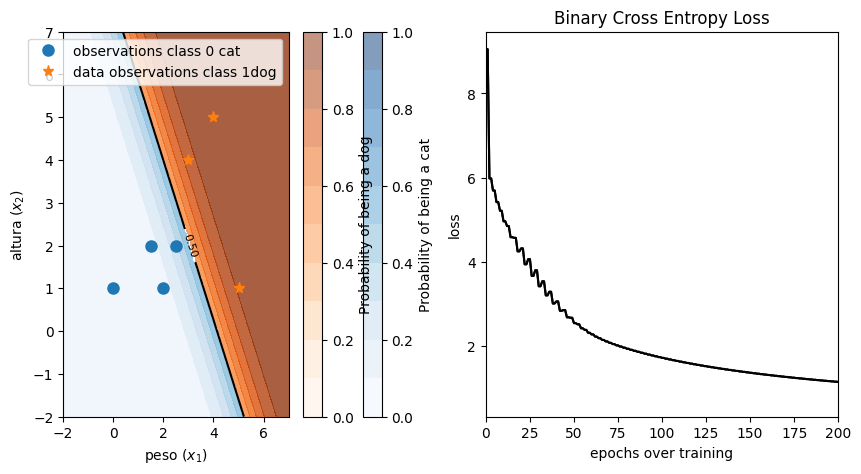

In [21]:
get_video = True

if get_video:
    # Create temporary file for video creation
    video_filename = "/tmp/aux.mp4"

    ## video writer
    writer = imageio.get_writer(video_filename, format="FFMPEG", mode="I", fps=1, codec="libx264")


## create the mesh for height and altura to visualize. This is know done different because
#  I need to create features so that I can used matrix multiplication
loss_type = 'bce'
np.random.seed(cg.seed)
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (10,5))
plt.subplots_adjust(wspace=0.2) 

# domain over where we want to plot the function implemented by the NNet.
# since input is 2D we need a mesh
N_points_domain = cg.N_domain_x
thr_prob = cg.thr # use to plot our classification guess
x1, x2 = np.meshgrid(np.linspace(cg.data_x1_lim_l,cg.data_x1_lim_u,N_points_domain),np.linspace(cg.data_x2_lim_l,cg.data_x2_lim_u,N_points_domain))

# reshape for neural network
x_range = np.hstack((np.reshape(x1, (N_points_domain**2,1)),np.reshape(x2, (N_points_domain**2,1))))

# allocate memory to plot decision thresholds
y_range_plot = np.zeros((N_points_domain,N_points_domain), np.float32)

## Run gradient descent
lr = 0.1
epochs = 200

## Initialize model
w,b = create_computation_graph_linear(n_in = 2,n_out = 1)
loss_over_training = []
for e in range(epochs):

    ## forward plus backward
    grad_w, grad_b = cg.losses_named[loss_type].grad_loss_fun(x_data,t_data, w, b)
    
    ## Compute loss at current parameter value
    y_data = computation_graph_sigmoid(x_data,w,b)
    
    loss = cg.losses_named[loss_type].loss_fun(t_data, y_data)
        
    loss_acc = np.sum(loss)
        
    loss_over_training.append(loss_acc)
    
    ## =============
    ## Append losses
    loss_over_training.append(loss_acc)
   
    # start plotting
    if get_video:
        ## Take predictions over the grid
        y_range = computation_graph_sigmoid(x_range,w,b)
    
        # reshape back to plotting
        y_range = np.reshape(y_range, (N_points_domain,N_points_domain))
    
        ax1.cla()
        ax2.cla()

        # plot dataset    
        ax1.plot(x_data[idx_class0][:,0],x_data[idx_class0][:,1],'o', color = color_c0, markersize = 8, label = r'observations class 0 cat')
        ax1.plot(x_data[idx_class1][:,0],x_data[idx_class1][:,1],'*', color = color_c1,markersize = 8, label = r'data observations class 1dog')
        ax1.set_xlabel(cg.data_x1_name)
        ax1.set_ylabel(cg.data_x2_name)

        ## plot prediction probability for class 1 and 0
        idx_range1 = y_range > thr_prob
        idx_range0 = ~idx_range1

        y_range_plot[idx_range1] = y_range[idx_range1]
        y_range_plot[idx_range0] = np.nan

        ax1.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Oranges"), alpha = 0.5)
        contourf1 = ax1.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Oranges"), alpha = 0.5)

        y_range_plot[idx_range0] = y_range[idx_range0]
        y_range_plot[idx_range1] = np.nan

        ax1.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Blues"), alpha = 0.5)
        contourf2 = ax1.contourf(x1, x2, y_range_plot, levels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap = plt.cm.get_cmap("Blues"), alpha = 0.5)

        # decision threshold
        contour1 = ax1.contour(x1, x2, y_range, levels = [thr_prob], colors = ["k"], linewidth = 4, label = f'decision threshold p = {thr_prob}')
        ax1.clabel(contour1, inline=True, fontsize=8, fmt="%.2f")

        ## set legend
        ax1.legend()

        ## set contour bar level
        if e == 0:
            cbar2 = fig.colorbar(contourf2, ax=ax1, orientation='vertical')
            cbar2.set_label(f'Probability of being a {cg.name_class0}')

            #cbar1 = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Ajusta la posición [izq, abajo, ancho, alto]
            cbar1 = fig.colorbar(contourf1, ax=ax1, orientation='vertical')
            cbar1.set_label(f'Probability of being a {cg.name_class1}')

        ## ===================
        ## Plot loss over ax 2
        ax2.plot(np.arange(len(loss_over_training)),loss_over_training, color = 'k')

        ax2.set_ylabel(f'loss')

        ax2.set_xlabel(f'epochs over training')

        ax2.set_title(f'{cg.losses_named[loss_type].loss_name} Loss')

        ax2.set_xlim([0 , epochs])

        
        ## Cortesía de chatGPT (desde linea siguiente hasta el final de esta celda):
        ## save images for later display
        buf = BytesIO()
        fig.savefig(buf, format="png", dpi=100)
    
        buf.seek(0)
        frame = imageio.imread(buf) 
        writer.append_data(frame) 
    
    ## update parameter
    w = w - lr*grad_w
    b = b - lr*grad_b

if get_video:
    writer.close() 

ax2.plot(np.arange(len(loss_over_training)),loss_over_training, color = 'k')

ax2.set_ylabel(f'loss')

ax2.set_xlabel(f'epochs over training')

ax2.set_title(f'{cg.losses_named[loss_type].loss_name} Loss')

ax2.set_xlim([0 , epochs])

print(f"Obtained optimal parameters w={w} b = {b} with associated loss {loss_acc}")

In [22]:
# Mostrar el video en Jupyter Notebook
display(Video(data=video_filename, embed=True))
os.remove(video_filename)